In [38]:
import torch
import syft as sy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch import optim
from tqdm import tqdm
device = torch.device("cuda")
torch.manual_seed(5)

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset =  pd.read_csv('shuttle-unsupervised-ad.csv', header=None)
dataset.columns = ["a",'b','c','d', 'e', 'f' , 'g', 'h', 'i', 'j']
dataset.head()

,a,b,c,d,e,f,g,h,i,j
0,108.0,3.0,109.0,0.0,72.0,7.0,1.0,36.0,36.0,o
1,81.0,0.0,84.0,0.0,-14.0,-2.0,4.0,100.0,96.0,o
2,81.0,0.0,84.0,0.0,-20.0,16.0,4.0,105.0,102.0,o
3,76.0,-1.0,81.0,0.0,-42.0,-3.0,5.0,125.0,120.0,o
4,105.0,0.0,107.0,2.0,70.0,0.0,1.0,37.0,36.0,o


In [4]:
dataset.replace({"o":1, "n":0}, inplace=True)

In [5]:
dataset = (dataset - dataset.min())/(dataset.max() - dataset.min())

In [6]:
dataset.head()

,a,b,c,d,e,f,g,h,i,j
0,0.843750,0.695558,0.687500,0.507015,0.416667,0.458156,0.206107,0.624398,0.630225,1.0
1,0.562500,0.695092,0.492188,0.507015,0.278846,0.457834,0.229008,0.727127,0.726688,1.0
2,0.562500,0.695092,0.492188,0.507015,0.269231,0.458478,0.229008,0.735152,0.736334,1.0
3,0.510417,0.694936,0.468750,0.507015,0.233974,0.457799,0.236641,0.767255,0.765273,1.0
4,0.812500,0.695092,0.671875,0.507272,0.413462,0.457906,0.206107,0.626003,0.630225,1.0


In [7]:
set(dataset.j)

{0.0, 1.0}

In [8]:
X, y = Variable(torch.from_numpy(dataset[[cols for cols in dataset.columns if cols!='j']].values)).cuda(), Variable(torch.from_numpy(dataset.j.values)).cuda()

In [9]:
data_client1 = dataset.sample(frac=0.5)
data_client2 = dataset[~dataset.index.isin(data_client1.index)]

In [10]:
features_client1, target_client1 = data_client1[[cols for cols in data_client1.columns if cols!='j']], data_client1.j
features_client2, target_client2 = data_client2[[cols for cols in data_client2.columns if cols!='j']], data_client2.j

In [11]:
x_client1 = Variable(torch.from_numpy(features_client1.values), requires_grad = False).cuda().float()
x_client2 = Variable(torch.from_numpy(features_client2.values), requires_grad = False).cuda().float()

y_client1 = Variable(torch.from_numpy(target_client1.values), requires_grad = False).cuda().float()
y_client2 = Variable(torch.from_numpy(target_client2.values), requires_grad = False).cuda().float()

In [12]:
def model(In_size, H_size=14):
    if type(H_size) is not list:
        model = torch.nn.Sequential(
                    torch.nn.Linear(In_size, H_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(H_size, H_size),
                    torch.nn.Tanh(),
                    torch.nn.Linear(H_size, H_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(H_size, In_size))
            
    
    return model
    
loss_fn = torch.nn.MSELoss(size_average = False)

C:\Users\Shubham\Anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [13]:
auto_mod = model(dataset.shape[1] - 1, 14).cuda()

opt_auto = optim.SGD(params=auto_mod.parameters(), lr=1e-5)
loss_auto = torch.nn.MSELoss(size_average = False)

In [14]:
print(auto_mod)

Sequential(
  (0): Linear(in_features=9, out_features=14, bias=True)
  (1): ReLU()
  (2): Linear(in_features=14, out_features=14, bias=True)
  (3): Tanh()
  (4): Linear(in_features=14, out_features=14, bias=True)
  (5): ReLU()
  (6): Linear(in_features=14, out_features=9, bias=True)
)


In [15]:
def classification_model(In_size, H_size=10, out_size=1):
    model = torch.nn.Sequential(
                    torch.nn.Linear(In_size, H_size),
                    torch.nn.ReLU(),
                    torch.nn.Linear(H_size, H_size),
                    torch.nn.Tanh(),
                    torch.nn.Linear(H_size, out_size),
                    torch.nn.Sigmoid())
    return model


In [16]:
class_mod = classification_model(dataset.shape[1] - 1).cuda()
opt_class = optim.SGD(params=class_mod.parameters(), lr=1e-5)
loss_class = torch.nn.BCELoss().cuda()

In [17]:
print(class_mod)

Sequential(
  (0): Linear(in_features=9, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Tanh()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)


In [18]:
hook = sy.TorchHook(torch)

client_1 = sy.VirtualWorker(hook, id="client_1")
client_2 = sy.VirtualWorker(hook, id="client_2")

In [19]:
epoch = 20
batch_size= 256
batches = []
for i in range(0, len(x_client2), batch_size):
    batches.append((x_client1[i:( i + batch_size)].send(client_1), y_client1[i:( i + batch_size)].send(client_1)))
    batches.append((x_client2[i:( i + batch_size)].send(client_2), y_client2[i:( i + batch_size)].send(client_2)))

In [20]:
for __ in range(epoch):
    print('Epoch start\n')
    losses= []
    
    for batch in tqdm(batches):
        
        worker = batch[0].location
        auto_mod.send(worker)
        opt_auto.zero_grad()
        pred = auto_mod(batch[0])
        loss_val = loss_auto(pred, batch[0])
        loss_val.backward()
        
        opt_auto.step()
        auto_mod.get()
        losses.append(loss_val.get())
    
    print(sum(losses)/len(losses))



Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 26.75it/s]


tensor(344.6643, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.63it/s]


tensor(26.4847, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 26.82it/s]


tensor(5.9843, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.87it/s]


tensor(5.5707, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.55it/s]


tensor(5.5600, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.58it/s]


tensor(5.5560, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 28.01it/s]


tensor(5.5521, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.45it/s]


tensor(5.5480, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.83it/s]


tensor(5.5439, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.43it/s]


tensor(5.5398, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.73it/s]


tensor(5.5356, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.58it/s]


tensor(5.5313, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.14it/s]


tensor(5.5269, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.93it/s]


tensor(5.5225, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.66it/s]


tensor(5.5179, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 26.31it/s]


tensor(5.5133, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.28it/s]


tensor(5.5087, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.46it/s]


tensor(5.5041, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:07<00:00, 26.96it/s]


tensor(5.4994, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:06<00:00, 27.59it/s]


tensor(5.4948, device='cuda:0', grad_fn=<DivBackward0>)


In [21]:
x_client1 = auto_mod(Variable(torch.from_numpy(features_client1.values), requires_grad = False).cuda().float())
x_client2 = auto_mod(Variable(torch.from_numpy(features_client2.values), requires_grad = False).cuda().float())

In [22]:
epoch = 20
batch_size= 256
batches = []
for i in range(0, len(x_client2), batch_size):
    batches.append((x_client1[i:( i + batch_size)].send(client_1), y_client1[i:( i + batch_size)].send(client_1)))
    batches.append((x_client2[i:( i + batch_size)].send(client_2), y_client2[i:( i + batch_size)].send(client_2)))

In [23]:
for __ in range(epoch):
    print('Epoch start\n')
    losses= []
    for batch in tqdm(batches):
        worker = batch[0].location
        class_mod.send(worker)
        opt_class.zero_grad()
        pred = class_mod(batch[0])
        loss_val = loss_class(pred, batch[1])
        loss_val.backward()
        opt_class.step()
        class_mod.get()
        losses.append(loss_val.get())
    
    print(sum(losses)/len(losses))



Epoch start



  0%|                                                                                          | 0/182 [00:00<?, ?it/s]C:\Users\Shubham\Anaconda3\lib\site-packages\syft\frameworks\torch\tensors\interpreters\native.py:322: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  response = eval(cmd)(*args, **kwargs)
 98%|██████████████████████████████████████████████████████████████████████████████▋ | 179/182 [00:05<00:00, 33.40it/s]C:\Users\Shubham\Anaconda3\lib\site-packages\syft\frameworks\torch\tensors\interpreters\native.py:322: UserWarning: Using a target size (torch.Size([192])) that is different to the input size (torch.Size([192, 1])) is deprecated. Please ensure they have the same size.
  response = eval(cmd)(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.08it/s]


tensor(0.6701, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.89it/s]


tensor(0.6692, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.44it/s]


tensor(0.6682, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.53it/s]


tensor(0.6673, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.99it/s]


tensor(0.6664, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.96it/s]


tensor(0.6655, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.47it/s]


tensor(0.6646, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.84it/s]


tensor(0.6636, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.91it/s]


tensor(0.6627, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.30it/s]


tensor(0.6618, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.72it/s]


tensor(0.6609, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 35.26it/s]


tensor(0.6600, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.75it/s]


tensor(0.6591, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.86it/s]


tensor(0.6582, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 35.11it/s]


tensor(0.6573, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.82it/s]


tensor(0.6564, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 35.07it/s]


tensor(0.6555, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.51it/s]


tensor(0.6546, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.98it/s]


tensor(0.6537, device='cuda:0', grad_fn=<DivBackward0>)
Epoch start



100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:05<00:00, 34.80it/s]


tensor(0.6528, device='cuda:0', grad_fn=<DivBackward0>)


In [24]:
X = Variable(torch.from_numpy(dataset[[cols for cols in dataset.columns if cols!='j']].values.astype('float'))).cuda()

In [25]:
pred1 = np.array(class_mod(x_client1).cpu().detach())
pred2 = np.array(class_mod(x_client2).cpu().detach())

In [36]:
pred = np.vstack([pred1.reshape(-1, 1), pred2.reshape(-1, 1)])
pred = pred.reshape(-1,1)
pred = (pred - pred.min())/(pred.max() - pred.min())
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0
pred = pred.reshape(-1, 1)
target = np.vstack([y_client1.cpu().numpy().reshape(-1, 1), y_client2.cpu().numpy().reshape(-1, 1)])

In [37]:
print(classification_report(pred, target))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45588
         1.0       0.95      0.96      0.96       876

    accuracy                           1.00     46464
   macro avg       0.98      0.98      0.98     46464
weighted avg       1.00      1.00      1.00     46464



In [39]:
mat = confusion_matrix(pred, target)

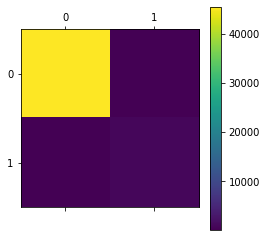

In [40]:
plt.matshow(mat)
plt.colorbar()

In [51]:
losses = [x.item() for x in losses]

Text(0, 0.5, 'loss')

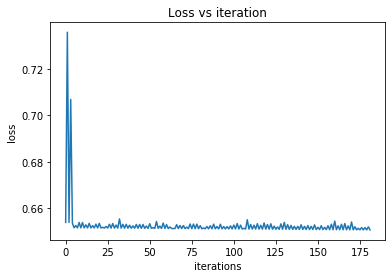

In [53]:
plt.plot(losses)
plt.title("Loss vs iteration")
plt.xlabel('iterations')
plt.ylabel('loss')